![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src="https://github.com/PracticumAI/practicumai.github.io/blob/84b04be083ca02e5c7e92850f9afd391fc48ae2a/images/icons/practicumai_computer_vision.png?raw=true" alt="Practicum AI: Computer Vision icon" align="right" width=50>
***

# Transfer Learning Implementation

Welcome back! In our previous exercise [01.0_transfer_learning_conepts.ipynb](01.0_transfer_learning_conepts.ipynb), we introduced the core concepts of **Transfer Learning** and experimented with fine-tuning. We saw how leveraging pre-trained models can significantly boost performance and reduce training time compared to starting from scratch.

In this notebook we'll expand into adapting powerful pre-trained language models for specific Natural Language Processing (NLP) tasks, focusing on two other, important transfer learning strategies. We'll:

* Implement **Feature Extraction** using a pre-trained Transformer model for text classification.
* Look closer at how to freeze the base model and train only a new classification head.
* Implement **LoRA (Low-Rank Adaptation)**, a Parameter-Efficient Fine-Tuning (PEFT) technique, to adapt the same pre-trained Transformer.
* Understand how LoRA modifies the model and drastically reduces the number of trainable parameters.
* Directly compare the results and efficiency of Feature Extraction versus LoRA on the same NLP task.

## A Direct Comparison

To make the comparison between Feature Extraction and LoRA as clear as possible, we will:

1.  Use the **same base pre-trained model** [DistilBERT - `distilbert-base-uncased`](https://huggingface.co/distilbert/distilbert-base-uncased) as the starting point for both methods.
2.  Apply both techniques to the **same text classification task** (e.g., Text Classification using the [Crop Market News Classification](https://www.kaggle.com/datasets/mcwemzy/crop-market-news-classification)). This dataset is hosted on the fantasic model zoo site, [Kaggle.com](kaggle.com)!
3.  Use the **same dataset** for training and evaluation in both parts.

This setup will allow us to directly observe the differences in implementation complexity, performance metrics, and the number of parameters trained.

### Prerequisites and Setup

* **Conceptual Understanding:** Ensure you're comfortable with the basic ideas of transfer learning, pre-trained models, and fine-tuning as covered in Notebook `01.0`.
* **Helper Functions:** We will utilize helper functions defined in [00.5_transfer_learning_helper.ipynb](00.5_transfer_learning_helper.ipynb). Please make sure you have access to that notebook or have run it previously to make the functions available.
* **Deep Learning Fundamentals:** As with the previous exercise a throrough understanding of how Large Language Models (LLMs) work is not required, but it is necessary to have a basic understanding of concepts like parameters, hyperparameters, and other Deep Learning fundamentals. If you do want to learn more about how LLMs work, we recommend NVidia's [Deep Learning Institute](https://developer.nvidia.com/dli) course on [Introduction to Transformer-Based Natural Language Processing](https://learn.nvidia.com/courses/course-detail?course_id=course-v1:DLI+S-FX-08+V1). This course is free and provides a solid foundation in the principles of Transformers and their applications in NLP.

## How to Use This Notebook (`FIX_ME`s)

In this notebook, you'll find sections marked with:

```
FIX_ME
# FIX_ME: <description of what to do>
```
These are places where you need to fill in missing code or make adjustments. The goal is to reinforce the key implementation steps for each technique.

If you get stuck, review the preceding explanations, check the documentation for the libraries used (PyTorch, Hugging Face), or consult the course's **GitHub Discussions page** [Link to GitHub Discussions - Placeholder] for hints and help from peers and instructors.

Let's get started with adapting our language model!


### 1. Import the libraries we will use

As always, we will start by importing the libraries we will use in this notebook.

In [1]:
# Import Libraries
import os
import sys
import time
import json
import requests
import zipfile

import torch
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import datasets
import peft
from peft import get_peft_model, LoraConfig, TaskType
import pandas as pd
import arff
from tqdm import tqdm
from scipy.io import arff as scipy_arff
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    matthews_corrcoef,
    classification_report,
    ConfusionMatrixDisplay,
)

/home/i.lutticken/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-02 16:44:59.796029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743626699.813189 4020490 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743626699.818609 4020490 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 16:44:59.835068: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical ope

#### Check for GPU availability

This cell will check that everything is configured correctly to use your GPU. If everything is correct, you should see something like: 

    Using GPU: type of GPU

If you see:
    
    Using CPU
    
Either you do not have a GPU or the kernel is not correctly configured to use it. You might be able to run this notebook, but some sections will take a loooooong time!

In [2]:
# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA A100-SXM4-80GB


### 2. Getting the data

Today's dataset is the [Crop Market News Classification](https://www.kaggle.com/datasets/mcwemzy/crop-market-news-classification) dataset. This dataset contains crop market news articles and their corresponding categories. The goal is to classify the articles into their respective categories using both Feature Extraction and LoRA.

In [3]:
# Download the dataset, extract it to the data folder and remove the zip file
download_path = "https://data.rc.ufl.edu/pub/practicum-ai/Transfer_Learning_Intermediate/crop_market_news.zip"
zip_path = "data/crop_market_news.zip"
data_path = "data"

# Paths to dataset - UPDATED to use the correct filename
dataset = os.path.join(data_path, "Crop.Market.News.Classification.arff")

# Check if the data is already loaded
if not (os.path.exists(dataset) and os.path.getsize(dataset) > 0):
    # Create the data directory if it does not exist
    if not os.path.exists(data_path):
        os.makedirs(data_path)

    # Download the zip file
    r = requests.get(download_path)
    with open(zip_path, "wb") as f:
        f.write(r.content)

    # Extract the zip file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(data_path)

    # Remove the zip file
    os.remove(zip_path)
    print(f"Data has been downloaded an unziped at {data_path}")
else:
    print("Data is already downloaded.")

Data is already downloaded.


### 3. Looking at the data

The dataset contains a number of columns, but we will only use the `text` and `label` columns. The `text` column contains the news articles, and the `label` column contains the corresponding categories.

In [4]:
# Load the dataset
# Check if the dataset file exists and is not empty
try:
    # Use liac-arff to load the ARFF file
    with open(dataset, "r") as f:
        arff_data = arff.load(f)
        data = pd.DataFrame(
            arff_data["data"], columns=[attr[0] for attr in arff_data["attributes"]]
        )
except FileNotFoundError:
    print(f"ERROR: Dataset file not found at {dataset}.")
    print("Please ensure you have downloaded the dataset and the path is correct.")
    data = None  # Set data to None if file not found

if data is not None:
    # Convert to Pandas DataFrame
    df = pd.DataFrame(data)
    print(f"Loaded DataFrame shape: {df.shape}")

    # Decode byte strings (Common in ARFF)
    # Identify potential text columns (adjust names based on actual columns in meta/df.info())
    text_col = "text"
    label_col = "category"

    if text_col in df.columns and df[text_col].dtype == "object":
        # Check if decoding is needed (inspect first element)
        if isinstance(df[text_col].iloc[0], bytes):
            print(f"Decoding byte strings in column '{text_col}'...")
            df[text_col] = df[text_col].str.decode("utf-8")

    if label_col in df.columns and df[label_col].dtype == "object":
        if isinstance(df[label_col].iloc[0], bytes):
            print(f"Decoding byte strings in column '{label_col}'...")
            df[label_col] = df[label_col].str.decode("utf-8")

    # Map String Labels to Integer IDs
    unique_labels = df[label_col].unique()
    num_labels = len(unique_labels)

    # Create mappings
    label2id = {label: i for i, label in enumerate(unique_labels)}
    id2label = {i: label for label, i in label2id.items()}

    # Apply mapping to create a new 'label' column
    df["label"] = df[label_col].map(label2id)

    print(f"Number of classes: {num_labels}")
    print("Label mappings created:")
    print(f"  label2id: {label2id}")
    print(f"  id2label: {id2label}")

    # Inspect the DataFrame
    print("\nDataFrame Head:")
    print(df.head())
    print("\nDataFrame Info:")
    df.info()
    print("\nLabel Distribution:")
    print(df["label"].value_counts())

    # Keep only relevant columns (text and integer label)
    df = df[[text_col, "label"]]
    df = df.rename(columns={text_col: "text"})  # Ensure text column is named 'text'
else:
    print("Skipping DataFrame processing as data was not loaded.")

Loaded DataFrame shape: (217, 2)
Number of classes: 2
Label mappings created:
  label2id: {'corn': 0, 'wheat': 1}
  id2label: {0: 'corn', 1: 'wheat'}

DataFrame Head:
                                                text category  label
0  The corn market is expected to rise due to inc...     corn      0
1  Wheat prices fall as harvest yields exceed exp...    wheat      1
2   Traders predict a bumper crop for corn this year     corn      0
3  Farmers struggle to keep up with demand for wheat    wheat      1
4  USDA reports higher-than-expected corn yields ...     corn      0

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      217 non-null    object
 1   category  217 non-null    object
 2   label     217 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 5.2+ KB

Label Distribution:
1    116
0    101
Name: label, dtype:

### 4. Preprocessing the data

Now, let's convert our Pandas DataFrame into the Hugging Face `datasets` format, which integrates seamlessly with the `transformers` library. Since the original dataset doesn't specify train/test splits, we'll create our own train and validation sets.


In [5]:
if data is not None:
    # Convert Pandas DataFrame to Hugging Face Dataset
    hf_dataset = datasets.Dataset.from_pandas(df)
    print("\nConverted to Hugging Face Dataset:")
    print(hf_dataset)

    # Split into training and validation sets (e.g., 80% train, 20% validation)
    train_test_split_ratio = 0.20
    dataset_dict = hf_dataset.train_test_split(
        test_size=train_test_split_ratio, shuffle=True, seed=42
    )  # Use seed for reproducibility

    # Rename for clarity
    train_ds = dataset_dict["train"]
    eval_ds = dataset_dict["test"]

    print("\nSplit into Train and Validation Sets:")
    print(f"  Training examples: {len(train_ds)}")
    print(f"  Validation examples: {len(eval_ds)}")
    print(train_ds)  # Show structure

    # Initialize tokenizer
    model_name = "bert-base-uncased"  # Change to your preferred model
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenize the dataset
    def tokenize_function(example):
        return tokenizer(
            example["text"], truncation=True, padding="max_length", max_length=128
        )

    train_ds = train_ds.map(tokenize_function, batched=True)
    eval_ds = eval_ds.map(tokenize_function, batched=True)

    train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    eval_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
else:
    print("Skipping Dataset preparation as data was not loaded.")
    train_ds, eval_ds = None, None  # Set to None


Converted to Hugging Face Dataset:
Dataset({
    features: ['text', 'label'],
    num_rows: 217
})

Split into Train and Validation Sets:
  Training examples: 173
  Validation examples: 44
Dataset({
    features: ['text', 'label'],
    num_rows: 173
})


Map: 100%|██████████| 44/44 [00:00<00:00, 6309.16 examples/s]


### 5. Set up the model and tokenizer

We will use the `distilbert-base-uncased` model and tokenizer from Hugging Face. This model is a smaller, faster, and lighter version of BERT *(Bidirectional Encoder Representations from Transformers)* that retains 97% of BERT's language understanding while being 60% faster and 40% smaller. It is a great choice for text classification tasks, especially when computational resources are limited. The `distilbert-base-uncased` model is pre-trained on a large corpus of English text and is designed to handle uncased text (i.e., it does not differentiate between uppercase and lowercase letters), making it ideal for our task. We will also set up the training arguments for both Feature Extraction and LoRA.

In [6]:
# Setting up models for LoRA and Feature Extraction

# --- LoRA Setup ---
# Load base model for LoRA
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Adjust based on your classification task
    return_dict=True,
)

# Define LoRA configuration
lora_config = LoraConfig(
    r=16,  # Rank of the update matrices
    lora_alpha=32,  # Scaling factor
    target_modules=["query", "key", "value"],  # Which modules to apply LoRA to
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS,  # For sequence classification tasks
)

# Create LoRA model
lora_model = get_peft_model(base_model, lora_config)
print(
    f"LoRA model setup complete. Trainable parameters: {sum(p.numel() for p in lora_model.parameters() if p.requires_grad)}"
)

# --- Feature Extraction Setup ---
# Load the base model for feature extraction
feature_extractor_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Adjust based on your classification task
    return_dict=True,
)

# Freeze all parameters
for param in feature_extractor_model.parameters():
    param.requires_grad = False

# Unfreeze just the classification head for fine-tuning
for param in feature_extractor_model.classifier.parameters():
    param.requires_grad = True

# Create dataloaders
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(
    train_ds, shuffle=True, batch_size=16, collate_fn=data_collator
)
eval_dataloader = DataLoader(eval_ds, batch_size=16, collate_fn=data_collator)

print(
    f"Feature extraction model setup complete. Trainable parameters: {sum(p.numel() for p in feature_extractor_model.parameters() if p.requires_grad)}"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA model setup complete. Trainable parameters: 886274
Feature extraction model setup complete. Trainable parameters: 1538


### 6. Training the models

We will train two models: one using Feature Extraction and the other using LoRA. We will use the same training arguments for both models to ensure a fair comparison. The main difference will be in the training process: 
A. For Feature Extraction, we will freeze the base model and train only the classification head.
B. For LoRA, we will use the LoRA technique to adapt the entire model. 

We will evaluate both models on the validation set and compare their performance in the section 7.

In [7]:
# Training and Evaluation Functions

def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        progress_bar.set_postfix({"loss": loss.item()})

    return total_loss / len(dataloader)


def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    references = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            predictions.extend(preds)
            references.extend(labels)

    # Calculate metrics
    accuracy = accuracy_score(references, predictions)
    f1 = f1_score(references, predictions, average="weighted")

    return {"loss": total_loss / len(dataloader), "accuracy": accuracy, "f1": f1}


def train_model(model, train_dataloader, eval_dataloader, num_epochs=3, device="cuda"):
    # Set up optimizer and scheduler
    optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=5e-5)

    num_training_steps = num_epochs * len(train_dataloader)
    scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    # Move model to device
    model = model.to(device)

    # Training loop
    results = {"train_loss": [], "eval_loss": [], "eval_accuracy": [], "eval_f1": []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training
        train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, device)
        results["train_loss"].append(train_loss)

        # Evaluation
        eval_metrics = evaluate(model, eval_dataloader, device)
        results["eval_loss"].append(eval_metrics["loss"])
        results["eval_accuracy"].append(eval_metrics["accuracy"])
        results["eval_f1"].append(eval_metrics["f1"])

        print(
            f"Train Loss: {train_loss:.4f} | "
            + f"Eval Loss: {eval_metrics['loss']:.4f} | "
            + f"Accuracy: {eval_metrics['accuracy']:.4f} | "
            + f"F1 Score: {eval_metrics['f1']:.4f}"
        )

    return results

#### 6.1 Executing the training

We've broken out the training process into a separate function to keep the code clean and organized, and to make it easier to change the hyperparameters later if one was so inclined.

In [8]:
# LoRA training
print("Training LoRA model...")
lora_results = train_model(
    lora_model, train_dataloader, eval_dataloader, num_epochs=10, device=device
)
print("\nLoRA training completed!")

print("\nTraining feature extraction model...")
# Feature extraction training
feature_extraction_results = train_model(
    feature_extractor_model,
    train_dataloader,
    eval_dataloader,
    num_epochs=10,
    device=device,
)
print("\nFeature extraction training completed!")

Training LoRA model...
Epoch 1/10


Train Loss: 0.6765 | Eval Loss: 0.7138 | Accuracy: 0.4545 | F1 Score: 0.3755
Epoch 2/10


Train Loss: 0.6686 | Eval Loss: 0.7212 | Accuracy: 0.4545 | F1 Score: 0.3755
Epoch 3/10


Train Loss: 0.6539 | Eval Loss: 0.7278 | Accuracy: 0.4545 | F1 Score: 0.3755
Epoch 4/10


Train Loss: 0.6469 | Eval Loss: 0.7254 | Accuracy: 0.4545 | F1 Score: 0.3755
Epoch 5/10


Train Loss: 0.6343 | Eval Loss: 0.7206 | Accuracy: 0.4773 | F1 Score: 0.4119
Epoch 6/10


Train Loss: 0.6284 | Eval Loss: 0.7127 | Accuracy: 0.5000 | F1 Score: 0.4619
Epoch 7/10


Train Loss: 0.6229 | Eval Loss: 0.7134 | Accuracy: 0.5000 | F1 Score: 0.4619
Epoch 8/10


Train Loss: 0.6414 | Eval Loss: 0.7088 | Accuracy: 0.5000 | F1 Score: 0.4619
Epoch 9/10


Train Loss: 0.6261 | Eval Loss: 0.7039 | Accuracy: 0.4773 | F1 Score: 0.4443
Epoch 10/10


Train Loss: 0.6159 | Eval Loss: 0.7028 | Accuracy: 0.4773 | F1 Score: 0.4443

LoRA training completed!

Training feature extraction model...
Epoch 1/10


Train Loss: 0.6879 | Eval Loss: 0.7312 | Accuracy: 0.4545 | F1 Score: 0.2841
Epoch 2/10


Train Loss: 0.6946 | Eval Loss: 0.7239 | Accuracy: 0.4545 | F1 Score: 0.2841
Epoch 3/10


Train Loss: 0.6816 | Eval Loss: 0.7238 | Accuracy: 0.4545 | F1 Score: 0.2841
Epoch 4/10


Train Loss: 0.6775 | Eval Loss: 0.7272 | Accuracy: 0.4545 | F1 Score: 0.2841
Epoch 5/10


Train Loss: 0.6901 | Eval Loss: 0.7266 | Accuracy: 0.4545 | F1 Score: 0.2841
Epoch 6/10


Train Loss: 0.6801 | Eval Loss: 0.7240 | Accuracy: 0.4545 | F1 Score: 0.2841
Epoch 7/10


Train Loss: 0.6986 | Eval Loss: 0.7252 | Accuracy: 0.4545 | F1 Score: 0.2841
Epoch 8/10


Train Loss: 0.6829 | Eval Loss: 0.7263 | Accuracy: 0.4545 | F1 Score: 0.2841
Epoch 9/10


Train Loss: 0.6919 | Eval Loss: 0.7251 | Accuracy: 0.4545 | F1 Score: 0.2841
Epoch 10/10


Train Loss: 0.6875 | Eval Loss: 0.7244 | Accuracy: 0.4545 | F1 Score: 0.2841

Feature extraction training completed!


### 7. Evaluating the models

After training both models, we will evaluate their performance on the validation set. We will compare the accuracy, loss, and examine how the training process proceeded with respect to each approach's trainable parameters. This will help us understand the trade-offs between Feature Extraction and LoRA in terms of performance and efficiency.

Evaluating and comparing models...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metric          LoRA       Feature Extraction  
accuracy        0.4773   0.4545
precision       0.5041   0.2066
recall          0.4773   0.4545
f1              0.4443   0.2841
auc             0.6625   0.4896

Inference time (s):
LoRA: 0.0381
Feature Extraction: 0.0236

Trainable parameters:
LoRA: 886,274
Feature Extraction: 1,538


<Figure size 640x480 with 0 Axes>

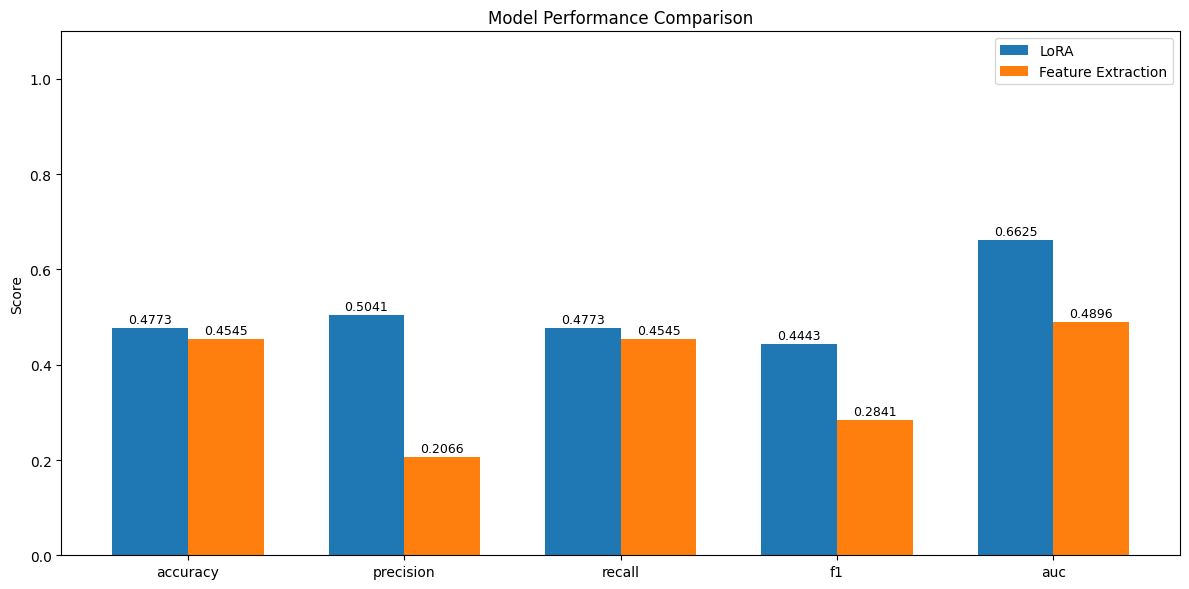

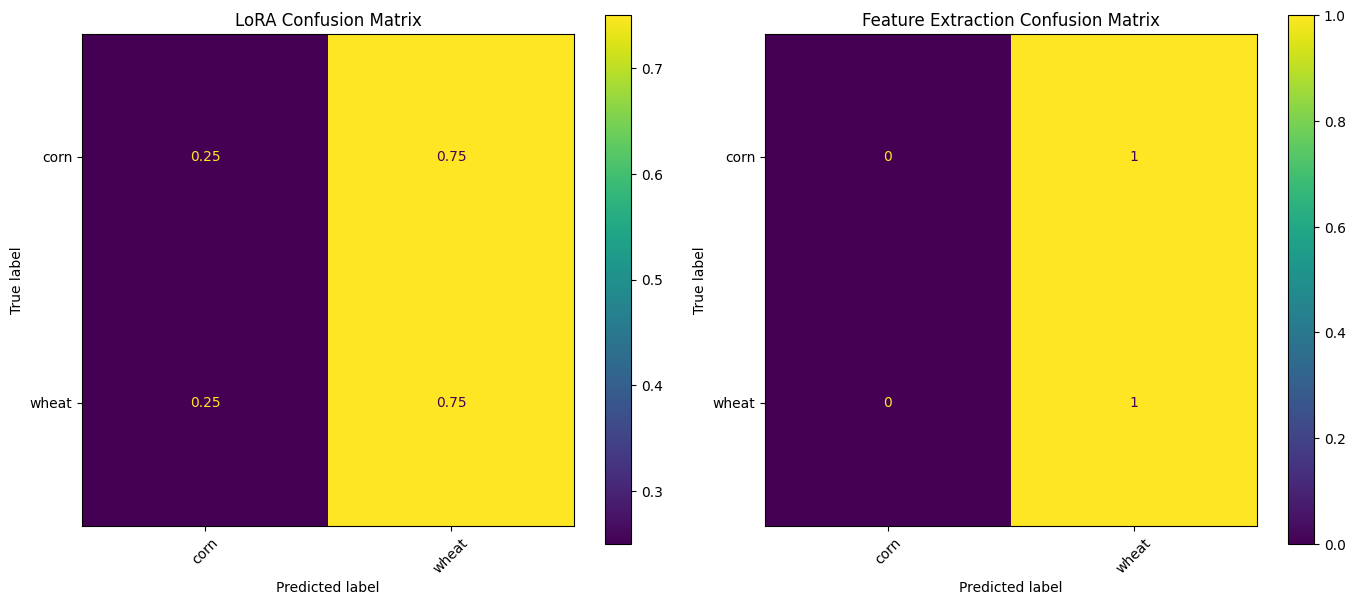


Plotting learning curves...


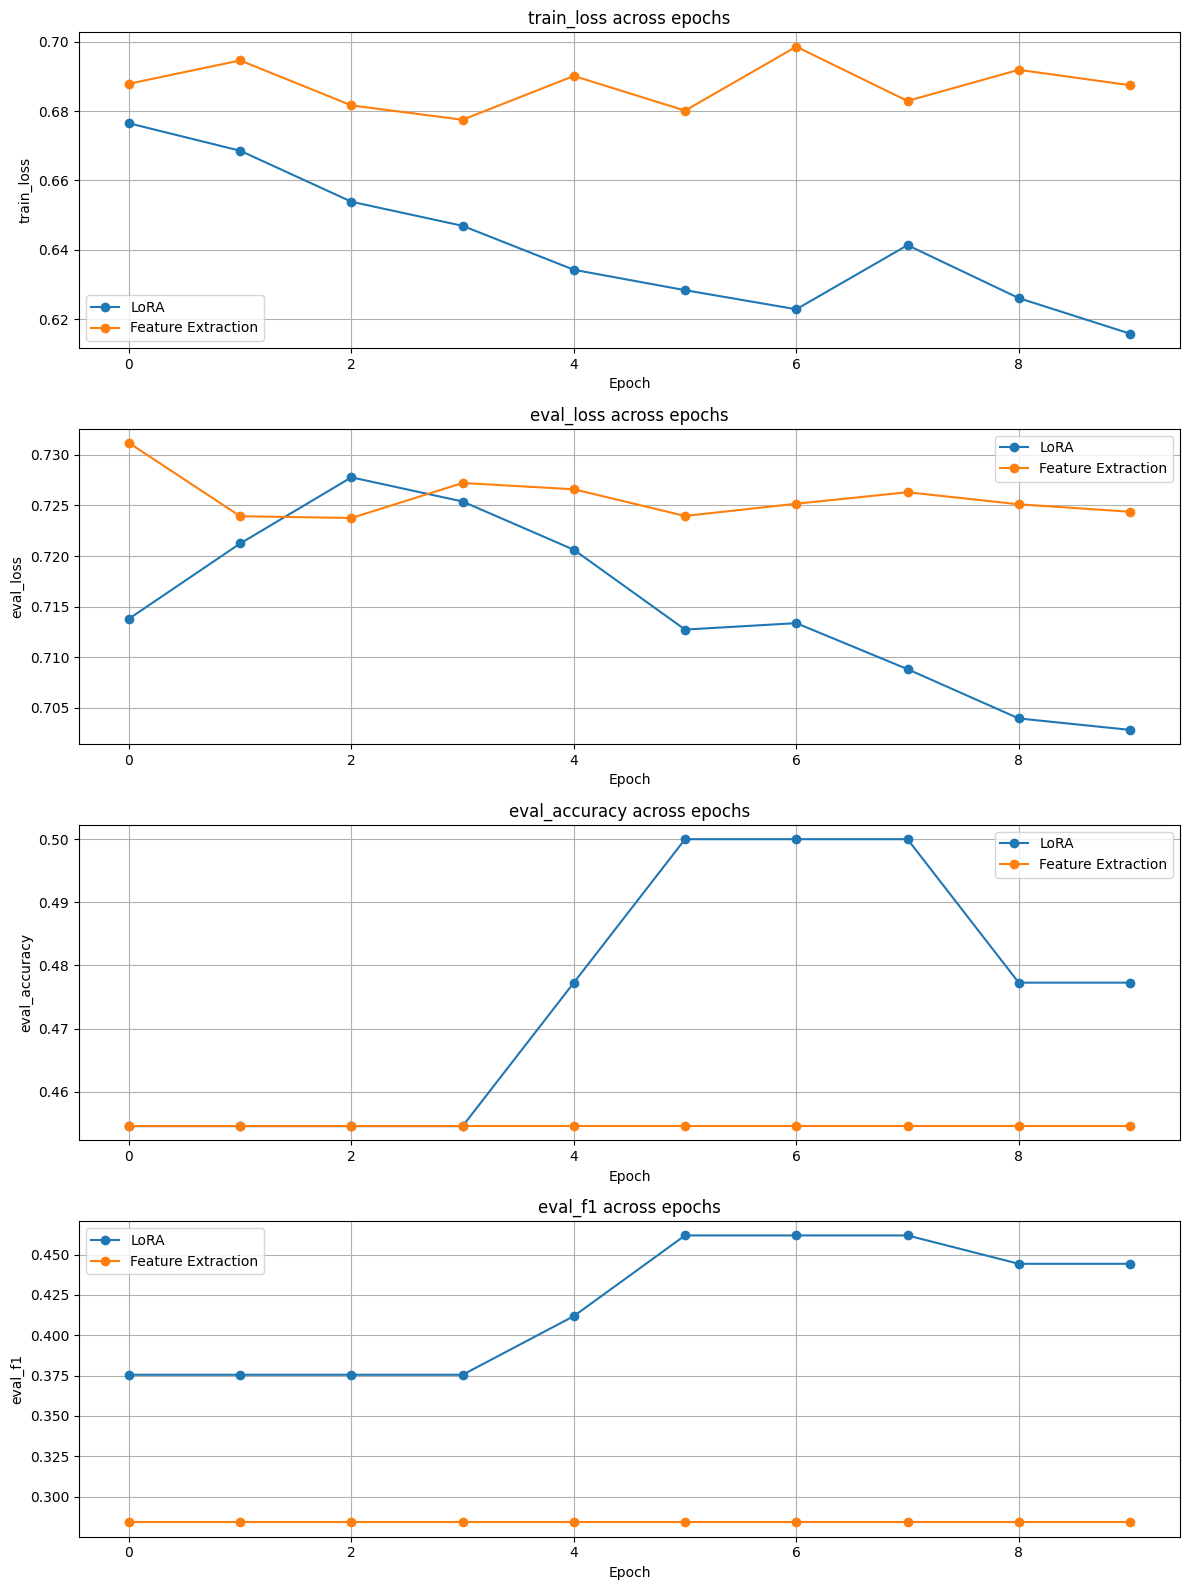

In [9]:
# Comprehensive evaluate the models
def get_comprehensive_metrics(y_true, y_pred, y_scores=None):
    """
    Calculate comprehensive metrics for model evaluation

    Parameters:
    y_true: Ground truth labels
    y_pred: Predicted labels
    y_scores: Prediction probabilities (for ROC AUC)
    """
    # Basic classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted"
    )

    # ROC AUC (if probabilities available)
    auc = None
    if y_scores is not None:
        # For binary classification
        if y_scores.shape[1] == 2:
            auc = roc_auc_score(y_true, y_scores[:, 1])
        # For multi-class
        else:
            auc = roc_auc_score(y_true, y_scores, multi_class="ovr", average="weighted")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
    }


def plot_model_comparison_bars(lora_metrics, fe_metrics):
    """Create bar chart comparing LoRA and Feature Extraction metrics"""
    metrics = list(lora_metrics.keys())

    # Filter out None values
    valid_metrics = [
        m for m in metrics if lora_metrics[m] is not None and fe_metrics[m] is not None
    ]

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(valid_metrics))
    width = 0.35

    # Plot bars
    ax.bar(x - width / 2, [lora_metrics[m] for m in valid_metrics], width, label="LoRA")
    ax.bar(
        x + width / 2,
        [fe_metrics[m] for m in valid_metrics],
        width,
        label="Feature Extraction",
    )

    # Add labels and formatting
    ax.set_ylabel("Score")
    ax.set_title("Model Performance Comparison")
    ax.set_xticks(x)
    ax.set_xticklabels(valid_metrics)
    ax.legend()

    # Add value labels on bars
    for i, v in enumerate([lora_metrics[m] for m in valid_metrics]):
        ax.text(i - width / 2, v + 0.01, f"{v:.4f}", ha="center", fontsize=9)
    for i, v in enumerate([fe_metrics[m] for m in valid_metrics]):
        ax.text(i + width / 2, v + 0.01, f"{v:.4f}", ha="center", fontsize=9)

    plt.ylim(0, 1.1)  # Ensure there's space for labels
    plt.tight_layout()
    return fig


def compare_models_learning_curves(results_dict, metric_names=None):
    """Compare different models based on their evaluation metrics"""
    if metric_names is None:
        metric_names = ["eval_accuracy", "eval_f1"]

    # Create a figure with subplots for each metric
    fig, axes = plt.subplots(len(metric_names), 1, figsize=(12, 4 * len(metric_names)))
    if len(metric_names) == 1:
        axes = [axes]

    for i, metric in enumerate(metric_names):
        for model_name, results in results_dict.items():
            if metric in results:
                axes[i].plot(results[metric], marker="o", label=f"{model_name}")

        axes[i].set_title(f"{metric} across epochs")
        axes[i].set_xlabel("Epoch")
        axes[i].set_ylabel(metric)
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    return fig


def evaluate_and_compare(
    lora_model, feature_extraction_model, test_dataloader, device, id2label=None
):
    # Get predictions
    lora_preds, lora_true, lora_scores, lora_time = get_predictions(
        lora_model, test_dataloader, device
    )
    fe_preds, fe_true, fe_scores, fe_time = get_predictions(
        feature_extraction_model, test_dataloader, device
    )

    # Get metrics
    lora_metrics = get_comprehensive_metrics(lora_true, lora_preds, lora_scores)
    fe_metrics = get_comprehensive_metrics(fe_true, fe_preds, fe_scores)

    # Print comparison table
    print(f"{'Metric':<15} {'LoRA':<10} {'Feature Extraction':<20}")
    print("=" * 45)
    for metric in lora_metrics.keys():
        if lora_metrics[metric] is not None and fe_metrics[metric] is not None:
            print(f"{metric:<15} {lora_metrics[metric]:.4f}   {fe_metrics[metric]:.4f}")

    # Print efficiency metrics
    print(f"\nInference time (s):")
    print(f"LoRA: {lora_time:.4f}")
    print(f"Feature Extraction: {fe_time:.4f}")

    # Count trainable parameters
    lora_trainable = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
    fe_trainable = sum(
        p.numel() for p in feature_extraction_model.parameters() if p.requires_grad
    )
    print(f"\nTrainable parameters:")
    print(f"LoRA: {lora_trainable:,}")
    print(f"Feature Extraction: {fe_trainable:,}")

    # Plot comparison bar chart
    plt.figure(1)
    plot_model_comparison_bars(lora_metrics, fe_metrics)
    plt.tight_layout()
    plt.show()

    # Plot confusion matrices with class labels
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Get class labels for confusion matrix
    labels = None
    if id2label:
        labels = [id2label[i] for i in range(len(id2label))]

    # Create confusion matrices with labels
    cm1 = ConfusionMatrixDisplay.from_predictions(
        lora_true,
        lora_preds,
        ax=ax1,
        normalize="true",
        display_labels=labels if labels else None,
    )
    ax1.set_title("LoRA Confusion Matrix")
    ax1.tick_params(axis="x", rotation=45)

    cm2 = ConfusionMatrixDisplay.from_predictions(
        fe_true,
        fe_preds,
        ax=ax2,
        normalize="true",
        display_labels=labels if labels else None,
    )
    ax2.set_title("Feature Extraction Confusion Matrix")
    ax2.tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

    # Return metrics for further analysis if needed
    return {"lora": lora_metrics, "feature_extraction": fe_metrics}


def get_predictions(model, dataloader, device):
    """Get predictions, true labels, and measure inference time"""
    model.eval()
    predictions = []
    true_labels = []
    scores = []

    start_time = time.time()
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1).cpu().numpy()
            probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            predictions.extend(preds)
            true_labels.extend(labels)
            scores.append(probs)

    inference_time = time.time() - start_time
    return (
        np.array(predictions),
        np.array(true_labels),
        np.vstack(scores),
        inference_time,
    )


# Plot learning curves for both models
def plot_learning_curves(lora_results, fe_results):
    # Combine results for comparison
    results_dict = {"LoRA": lora_results, "Feature Extraction": fe_results}

    # Plot learning curves
    fig = compare_models_learning_curves(
        results_dict, ["train_loss", "eval_loss", "eval_accuracy", "eval_f1"]
    )
    plt.show()
    return fig


# Evaluate and compare models
if train_ds is not None and eval_ds is not None:
    print("Evaluating and comparing models...")
    metrics = evaluate_and_compare(
        lora_model, feature_extractor_model, eval_dataloader, device, id2label
    )

    # Plot learning curves
    print("\nPlotting learning curves...")
    plot_learning_curves(lora_results, feature_extraction_results)

## Breaking down the graphs

If your stats are a little rusty, you might need a bit of refresher to make sense of the graphs above. Expand the section below for explanations of the terms used above.

<details>
    
<summary>Click to expand for stats terms!</summary>

<p>

##### What is Precision?
Precision is the ratio of correctly predicted positive observations to the total predicted positives. An example in our fruit object detection task would be the ratio of correctly predicted apples to the total predicted apples. Higher precision values are better, as they indicate that the model is making more accurate predictions.

##### What is Recall?
Recall is the ratio of correctly predicted positive observations to the true number of observations of a class. An example in our fruit object detection task would be the ratio of correctly predicted apples to the total actual apples. Higher recall values are better, as they indicate that the model is making more accurate predictions.

##### What is Confidence?
Confidence is the probability that a model assigns to a prediction. In our fruit object detection task, the confidence is the probability that a model assigns to a fruit being an apple, orange, or any other fruit. Higher confidence values are better, as they indicate that the model is more certain about its predictions.

##### What is a confusion matrix?
A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm. The confusion matrix shows the ways in which your classification model is confused when it makes predictions. It gives you insight not only into the errors being made by your classifier but more importantly the types of errors that are being made.

##### What is the F1 Confidence Curve?
The F1 Confidence Curve is a plot of the F1 score against the confidence threshold. The F1 score is the harmonic mean of precision and recall, and it is a measure of a model's accuracy. The confidence threshold is the minimum confidence level that a model must have in order to make a prediction. The F1 Confidence Curve is used to determine the optimal confidence threshold for a model. The curve shows how the F1 score changes as the confidence threshold is varied. The goal is to find the confidence threshold that maximizes the F1 score. The highest point on the curve tells you the optimal confidence threshold where the model strikes the best balance between precision and recall. In our fruit object detection task, the F1 Confidence Curve would show how the F1 score changes as the confidence threshold is varied for each fruit class. Higher F1 scores are better, as they indicate that the model is making more accurate predictions.

##### What is AUC?
AUC stands for Area Under the Curve. It is a performance measurement for classification problems at various threshold settings. AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher AUC values are better, as they indicate that the model is better at distinguishing between classes.

</p>
</details>


### 8. Run inference

Finally, let's try out our models on some sample text. We will use the same sample text for both models to see how they perform on the same input.

In [10]:
# Interactive inference

def run_inference_on_text(text, lora_model, feature_model, tokenizer, device, id2label):
    """
    Run inference on user-provided text with both models

    Parameters:
    text (str): Input text for classification
    lora_model: Trained LoRA model
    feature_model: Trained Feature Extraction model
    tokenizer: Tokenizer for preprocessing
    device: Device to run inference on
    id2label (dict): Mapping from label ids to human-readable labels
    """
    # Move models to eval mode
    lora_model.eval()
    feature_model.eval()

    # Tokenize the input text
    inputs = tokenizer(
        text, return_tensors="pt", padding=True, truncation=True, max_length=512
    ).to(device)

    # Run inference with LoRA model
    with torch.no_grad():
        lora_outputs = lora_model(**inputs)
        fe_outputs = feature_model(**inputs)

        # Get predictions
        lora_logits = lora_outputs.logits
        fe_logits = fe_outputs.logits

        lora_probs = torch.nn.functional.softmax(lora_logits, dim=-1).cpu().numpy()[0]
        fe_probs = torch.nn.functional.softmax(fe_logits, dim=-1).cpu().numpy()[0]

        lora_pred_id = lora_logits.argmax(dim=-1).cpu().numpy()[0]
        fe_pred_id = fe_logits.argmax(dim=-1).cpu().numpy()[0]

        lora_pred_label = id2label[lora_pred_id]
        fe_pred_label = id2label[fe_pred_id]

    # Print results
    print("\n" + "=" * 50)
    print(f'Input Text: "{text}"')
    print("=" * 50)
    print("\nPredictions:")
    print(
        f"  LoRA Model: {lora_pred_label} (confidence: {lora_probs[lora_pred_id]:.4f})"
    )
    print(
        f"  Feature Extraction Model: {fe_pred_label} (confidence: {fe_probs[fe_pred_id]:.4f})"
    )

    print("\nConfidence Distribution:")
    print(f"{'Class':<20} {'LoRA':<10} {'Feature Extraction':<20}")
    print("-" * 50)
    for i, label in id2label.items():
        print(f"{label:<20} {lora_probs[i]:.4f}    {fe_probs[i]:.4f}")

    # Create a bar chart comparing prediction probabilities
    plt.figure(figsize=(10, 6))
    x = np.arange(len(id2label))
    width = 0.35

    plt.bar(x - width / 2, lora_probs, width, label="LoRA")
    plt.bar(x + width / 2, fe_probs, width, label="Feature Extraction")

    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.title("Prediction Probabilities")
    plt.xticks(x, [id2label[i] for i in range(len(id2label))])
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return {
        "lora": {"label": lora_pred_label, "probs": lora_probs},
        "feature_extraction": {"label": fe_pred_label, "probs": fe_probs},
    }


# Interactive demo function
def interactive_demo(lora_model, feature_model, tokenizer, device, id2label):
    """Run an interactive demo that lets users enter text and see predictions"""
    print("\n" + "=" * 50)
    print("Interactive Model Demo")
    print("=" * 50)
    print("Enter text to classify (or 'quit' to exit):")

    while True:
        text = input("\nYour text: ")
        if text.lower() == "quit":
            print("Exiting demo...")
            break
        if not text.strip():
            print("Please enter some text to classify.")
            continue

        run_inference_on_text(
            text, lora_model, feature_model, tokenizer, device, id2label
        )

#### 8.1 Run the inference

We've broken out the inference process into a separate function to keep the code clean and organized.


Input Text: "I love cereal."

Predictions:
  LoRA Model: corn (confidence: 0.5098)
  Feature Extraction Model: wheat (confidence: 0.5539)

Confidence Distribution:
Class                LoRA       Feature Extraction  
--------------------------------------------------
corn                 0.5098    0.4461
wheat                0.4902    0.5539


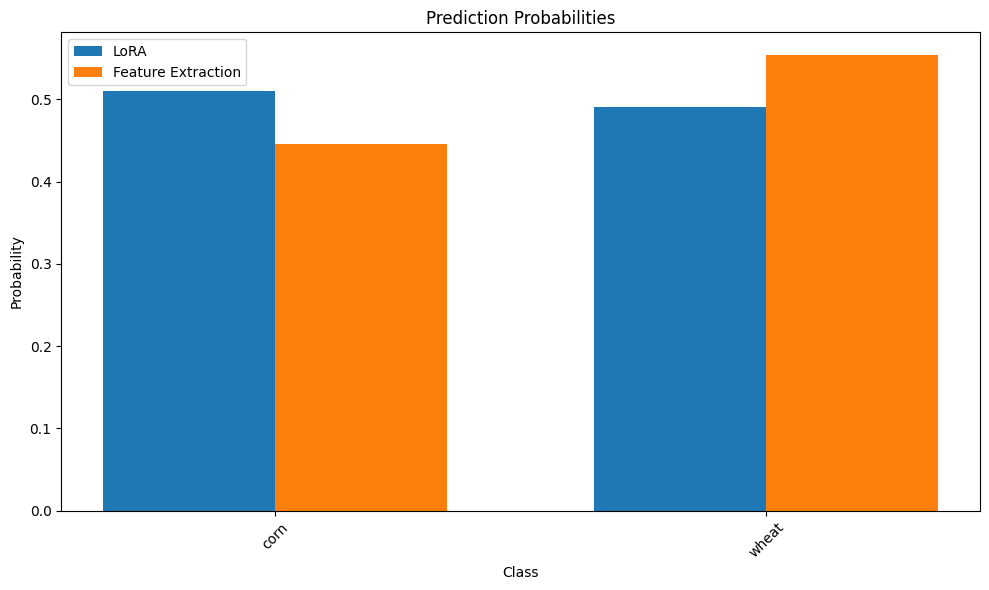

{'lora': {'label': 'corn',
  'probs': array([0.50977933, 0.49022067], dtype=float32)},
 'feature_extraction': {'label': 'wheat',
  'probs': array([0.44611454, 0.55388546], dtype=float32)}}

In [12]:
# For a one-time prediction, uncomment the two lines below.
sample_text = "I love cereal."
run_inference_on_text(sample_text, lora_model, feature_extractor_model, tokenizer, device, id2label)

# Example interactive usage.
# interactive_demo(lora_model, feature_extractor_model, tokenizer, device, id2label)

### 9. Conclusion

In this notebook, we implemented two transfer learning techniques for adapting a pre-trained Transformer model to a text classification task. We compared Feature Extraction and LoRA in terms of implementation complexity, performance metrics, and the number of parameters trained.

We observed that both techniques can achieve good performance, but they have different trade-offs in terms of efficiency and flexibility. Feature Extraction is simpler to implement and requires fewer resources, while LoRA offers more flexibility and can achieve better performance with fewer trainable parameters.

### Bonus Exercise
If you want to take this notebook a step further, try the following:
* Experiment with different pre-trained models from Hugging Face's model hub. Try using a larger model like `bert-base-uncased` or a more specialized model like `roberta-base`.
* Explore other NLP tasks, such as Named Entity Recognition (NER) or Question Answering (QA), using the same techniques.
* Try using different datasets from the Hugging Face datasets library. You can find a wide variety of datasets for different NLP tasks [here](https://huggingface.co/datasets).